In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import torch

In [ ]:
def read_data(folder):
    data = np.load(folder)
    data[data < 0] = 0
    return data

In [ ]:
piece_size = 64

In [ ]:
def make_new_blocks(data, start = 0, end = 512):
    ind = 0
    blocks = torch.empty(64, 256, piece_size, piece_size)
    for y in tqdm(range(0, 512, piece_size)):
      for x in range(start, end, piece_size):
        if x + piece_size > end:
          break
        blocks[ind] = torch.tensor(data[:, y : y + piece_size, x : x + piece_size])
        ind = ind + 1
    return blocks

In [ ]:
data = np.load('F:/Кожа/оценка/Andrey_Finger_left.npy')

In [ ]:
np.shape(data)

(256, 512, 512)

In [ ]:
blocks = make_new_blocks(data)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.75it/s]


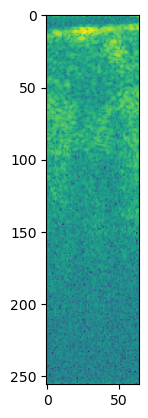

In [ ]:
plt.imshow(blocks[63, :, :, 1])

# Модель

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from tqdm import tqdm

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 32, 64, 128, 256, 512]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose3d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv3d(32, classes, kernel_size=1)


    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        # down layers
        concat_layers = []

        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        concat_layers = concat_layers[::-1]

        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])

            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)

        x = self.final_conv(x)

        return x

In [ ]:
def mask_from_model(num_model, data, blocks1, name):
    model = UNET(1, 5).to('cuda')
    model.load_state_dict(torch.load('C:/Users/MK/Nika/exp5/hyperparameter2/unet3d'+ num_model, map_location=torch.device('cuda')))
    model.eval()

    blocks1 = blocks1.to('cuda')

    out_model = np.zeros((blocks1.size()[0], 5, 256, piece_size, piece_size))
    for i in range(blocks1.size()[0]):
      out_model[i] = model(blocks1[i].unsqueeze(0).unsqueeze(0).to('cuda')).detach().cpu()

    data_out = np.zeros((5, 256, data.shape[1], data.shape[2]))
    for y_step in range(data.shape[1]//piece_size):
      for x_step in range(data.shape[2]//piece_size):
        x_begin = x_step*piece_size
        x_end = x_step*piece_size + piece_size
        y_begin = y_step*piece_size
        y_end = y_step*piece_size+piece_size
        num_block = x_step+y_step*(data.shape[2]//piece_size)
        data_out[:,:, y_begin:y_end, x_begin:x_end] = out_model[num_block, :,:,:,:]

    masks_out_with_bags = np.zeros((5, 256, data_out.shape[2], data_out.shape[3]))
    for x in tqdm(range(data_out.shape[3])):
      for y in range(data_out.shape[2]):
        for z in range(256):
          ind = np.argmax(data_out[:, z, y, x])
          masks_out_with_bags[ind, z, y, x] = 1
    np.save('C:/Users/MK/Nika/визоценка/' + name + '.npy', masks_out_with_bags)

In [ ]:
mask_from_model(str(0), data, blocks, 'Andrey_Finger_left')

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [02:44<00:00,  3.12it/s]


In [ ]:
def make_mask_and_save(name):
    i = 0
    data = np.load('F:/Кожа/оценка/'+ name + '_Finger_left.npy')
    blocks = make_new_blocks(data)
    mask_from_model(str(0), data, blocks, name + '_Finger_left')
    data = np.load('F:/Кожа/оценка/'+ name + '_Finger_right.npy')
    blocks = make_new_blocks(data)
    mask_from_model(str(0), data, blocks, name + '_Finger_right')

In [ ]:
make_mask_and_save('Katya')

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [02:45<00:00,  3.09it/s]


In [ ]:
%%time
make_mask_and_save('Lena')

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [02:48<00:00,  3.04it/s]


CPU times: total: 6min 6s
Wall time: 6min 37s


In [ ]:
%%time
make_mask_and_save('Valera')

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [02:45<00:00,  3.10it/s]


CPU times: total: 6min 5s
Wall time: 6min 36s


In [ ]:
%%time
make_mask_and_save('Andrey')

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [02:48<00:00,  3.03it/s]


CPU times: total: 6min 3s
Wall time: 6min 34s


In [ ]:
%%time
make_mask_and_save('Ksyusha')

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [02:48<00:00,  3.04it/s]


CPU times: total: 6min 24s
Wall time: 7min 1s


In [ ]:
%%time
make_mask_and_save('Yulya')

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [02:53<00:00,  2.95it/s]


CPU times: total: 6min 12s
Wall time: 6min 59s


In [ ]:
%%time
make_mask_and_save('Aleksey')

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [02:45<00:00,  3.09it/s]


CPU times: total: 6min 9s
Wall time: 6min 48s


In [ ]:
%%time
make_mask_and_save('Nastya')

# Визуальная проверка 2D модели

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

from tqdm import tqdm

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 32, 64, 128, 256, 512]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(32, classes, kernel_size=1)


    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        # down layers
        concat_layers = []

        for down in self.double_conv_downs:
            x = x.float()
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        concat_layers = concat_layers[::-1]

        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])

            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)

        x = self.final_conv(x)

        return x

In [ ]:
def give_me_masks_from_model(num_model, data, name):
    model = UNET(1, 5).to('cuda')
    model.load_state_dict(torch.load('C:/Users/MK/Nika/2D/exp1/hyperparameter0/unet2d' + str(num_model), map_location=torch.device('cuda')))
    model.eval()

    data2 = np.zeros((512, 256, 512))
    for x in range(512):
        data2[x, :, :] = data[:, :, x]
    data_blocks_tensor = torch.FloatTensor(data2)
    data_blocks_tensor = data_blocks_tensor.to('cuda')
    out_new = np.zeros((512, 5, 256, 512))
    for i in tqdm(range(512)):
        out_new[i] = model(data_blocks_tensor[i].unsqueeze(0).unsqueeze(0).to('cuda')).detach().cpu()
    masks = np.zeros((5, 256, 512, 512))
    for z in tqdm(range(256)):
        for x in range(512):
            for y in range(512):
                num = np.argmax(out_new[x, :, z, y])
                masks[num, z, y, x] = 1
    np.save('C:/Users/MK/Nika/2D/визоценка/' + name + '.npy', masks)

In [ ]:
def make_mask_and_save(name):
    i = 0
    data = np.load('F:/Кожа/оценка/'+ name + '_Finger_left.npy')
    data[data < 0] = 0
    give_me_masks_from_model(str(1), data, name + '_Finger_left')
    data = np.load('F:/Кожа/оценка/'+ name + '_Finger_right.npy')
    data[data < 0] = 0
    give_me_masks_from_model(str(1), data, name + '_Finger_right')

In [ ]:
%%time
make_mask_and_save('Katya')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:33<00:00,  1.67it/s]


CPU times: total: 5min 34s
Wall time: 5min 52s


In [ ]:
%%time
make_mask_and_save('Lena')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:34<00:00,  1.66it/s]


CPU times: total: 5min 36s
Wall time: 6min 5s


In [ ]:
%%time
make_mask_and_save('Valera')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:32<00:00,  1.68it/s]


CPU times: total: 5min 41s
Wall time: 6min 16s


In [ ]:
%%time
make_mask_and_save('Andrey')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:33<00:00,  1.67it/s]


CPU times: total: 5min 50s
Wall time: 6min 27s


In [ ]:
%%time
make_mask_and_save('Ksyusha')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:32<00:00,  1.68it/s]


CPU times: total: 5min 33s
Wall time: 6min 2s


In [ ]:
%%time
make_mask_and_save('Yulya')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:33<00:00,  1.67it/s]


CPU times: total: 5min 39s
Wall time: 6min 13s


In [ ]:
%%time
make_mask_and_save('Aleksey')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:33<00:00,  1.67it/s]


CPU times: total: 5min 40s
Wall time: 6min 8s


In [ ]:
%%time
make_mask_and_save('Nastya')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:32<00:00,  1.68it/s]


CPU times: total: 5min 38s
Wall time: 6min 7s


## Тонкая кожа проба

In [ ]:
def give_me_masks_from_model(num_model, data, name):
    model = UNET(1, 5).to('cuda')
    model.load_state_dict(torch.load('C:/Users/MK/Nika/2D/exp1/hyperparameter0/unet2d' + str(num_model), map_location=torch.device('cuda')))
    model.eval()

    data2 = np.zeros((512, 256, 512))
    for x in range(512):
        data2[x, :, :] = data[:, :, x]
    data_blocks_tensor = torch.FloatTensor(data2)
    data_blocks_tensor = data_blocks_tensor.to('cuda')
    out_new = np.zeros((512, 5, 256, 512))
    for i in tqdm(range(512)):
        out_new[i] = model(data_blocks_tensor[i].unsqueeze(0).unsqueeze(0).to('cuda')).detach().cpu()
    masks = np.zeros((5, 256, 512, 512))
    for z in tqdm(range(256)):
        for x in range(512):
            for y in range(512):
                num = np.argmax(out_new[x, :, z, y])
                masks[num, z, y, x] = 1
    np.save('C:/Users/MK/Nika/2D/тонк_кожа/визоценка/' + name + '.npy', masks)

In [ ]:
def make_mask_and_save(name):
    i = 0
    data = np.load('F:/data_base/'+ name + '.npy')
    data[data < 0] = 0
    give_me_masks_from_model(str(1), data, name)

In [ ]:
make_mask_and_save('АббясовРТ_за ухом')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:34<00:00,  1.66it/s]


In [ ]:
make_mask_and_save('КоржОН_плечо')

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [02:35<00:00,  1.65it/s]
